## Подготовка ноутбука
Импортируем все необходимые библиотеки, настроим флаги и константы, которыми будем пользоваться в эксперименте, и определим служебные функции, чтобы не отвлекаться на них в расчетной части эксперимента.

In [1]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

from tabulate import tabulate
from tqdm.notebook import tqdm

from itertools import product
from collections import namedtuple
from copy import deepcopy
import time
import numpy as np
import pandas as pd

# Подключаем локальные пакеты
import pyons
from pyons.models.rfid import pyradise
from pyons.models.rfid.serialization import Input

In [3]:
# Настраиваем matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

Определим переменные окружения, которые будут использоваться в эксперименте.

In [4]:
# Нужно ли пересчитывать все, или можно использовать результаты из файлов
RUN_SIMULATION = True

SIM_DATA_DIR = "data"
SIM_DATA_FILE = 'sim_data.csv'
SIM_DATA_PATH = os.path.join(SIM_DATA_DIR, SIM_DATA_FILE)

# Зададим число машин, проезд которых по сети мы будем моделировать.
# Чем выше это число, тем точнее результаты, но на их получение нужно больше времени.
NUM_PACKETS = 40

# Цветовая схема для графиков
CMAP_NAME = 'viridis'

In [5]:
def get_color(x):
    """
    Получить цвет из текущей карты.
    """
    return cm.get_cmap(CMAP_NAME)(x)

## Подготовка экспериментальных данных

Определим сетку, на которой будем проводить вычисления. В каждой симуляции мы будем 
вычислять зависимость вероятности идентификации от скорости. При проведении сравнений 
будем смотреть, как меняется вероятность, если один из параметров (Tari, M, ...) 
меняется, а остальные параметры - нет.

Сначала определим вспомогательную функцию `make_input()`, которая будет копировать 
`Input` и изменять некоторые его параметры.

In [6]:
def make_input(base, **kwargs) -> Input:
    inp = deepcopy(base)
    for key, value in kwargs.items():
        if key not in Input.__dataclass_fields__:
            raise KeyError(f'Input does not have key "{key}"')
        setattr(inp, key, value)
    return inp

In [36]:
V = np.arange(30, 130, 2.5)          # Скорость в км/ч
T = [6.25, 12.5, 18.75, 25]          # Tari
M = [1, 2, 4, 8]                     # Код ответа метки (FM0, M2, M4, M8)
P = [27, 29, 31.5]                   # Мощность считывателя
TID = [6, 12]                        # Размер TID в байтах
FLAG = ["A", "AB"]                   # Сценарии опроса

# Эти значения - центральные. Если какой-то из параметров в сетке меняется,
# то остальные параметры имеют фиксированные значения BASE_XXX.
BASE_V = 60
BASE_M = 2
BASE_T = 12.5
BASE_P = 31.5
BASE_TID = 6
BASE_FLAG = "AB"

# Определим базовый вход. Остальные входы будем строить с помощью
# make_input(), передавая этот вход в качестве базы.
BASE_INPUT = Input(
    tari=BASE_T,
    m=BASE_M,
    trext=False,
    q=4,
    reader_tx_power=BASE_P,
    vehicle_speed=BASE_V,
    tid_size=BASE_TID,
    use_reader_antenna_back=True,
    use_reader_antenna_front=True,
    use_tag_back=True,
    use_tag_front=True,
    reader_session_strategy=BASE_FLAG,
)

Построим сетку параметров. Так как в ней могут быть дубликаты (на всех линиях
будут точки с параметрами `BASE_XXX`), то удалим дубликаты с помощью `set()`.

In [11]:
def prod(*args):
    """Helper alias for list(product(...))"""
    return list(product(*args))


GRID = set(
    prod(V, TARI, (BASE_M,), (BASE_P,), (BASE_TID,), (BASE_FLAG,)) +
    prod(V, (BASE_T,), M, (BASE_P,), (BASE_TID,), (BASE_FLAG,)) +
    prod(V, (BASE_T,), (BASE_M,), P, (BASE_TID,), (BASE_FLAG,)) +
    prod(V, (BASE_T,), (BASE_M,), (BASE_P,), TID, (BASE_FLAG,)) +
    prod(V, (BASE_T,), (BASE_M,), (BASE_P,), (BASE_TID,), FLAG)
)

INPUTS = []
for speed, tari, m, power, tid_size, flag in GRID:
    base = make_input(
        BASE_INPUT, 
        vehicle_speed=speed, 
        tari=tari, 
        m=m, 
        reader_tx_power=power, 
        tid_size=tid_size,
        reader_session_strategy=flag,
    )
    
    INPUTS.append(base)
    
    # Для базового случая рассматриваем отдельно передние и задние номера.
    if (tari == BASE_T and m == BASE_M and 
        power == BASE_P and tid_size == BASE_TID and
        flag == BASE_FLAG
    ):
        INPUTS.append(make_input(base, use_tag_back=False))
        INPUTS.append(make_input(base, use_tag_front=False))    

print(f"Grid size = {len(INPUTS)}")

Grid size = 520


Сохраняем построенные входы в CSV.

In [12]:
if RUN_SIMULATION or not os.path.exists(SIM_DATA_PATH):
    df = pd.DataFrame(INPUTS)
    df.to_csv(SIM_DATA_PATH, index=False)
    print(f"Written {df.shape[0]} rows to {SIM_DATA_PATH}")
else:
    print(f"Sim data file exists, RUN_SIMULATION = False")

Written 520 rows to data/sim_data.csv


## Вызов имитационной модели

In [27]:
DF = pd.read_csv("data/sim_data_20.csv").sort_values('vehicle_speed')
print(f"Loaded {DF.shape[0]} rows")

Loaded 520 rows


В дальнейшем нам потребуется выделять подмножества, определим вспомогательные функции.

In [28]:
def subset(df=None, t=None, m=None, p=None, tid=None, flag=None, back=None, front=None):
    if df is None:
        df = DF
    conditions = []
    if t is not None:
        conditions.append(df.tari == t)
    if m is not None:
        conditions.append(df.m == m)
    if p is not None:
        conditions.append(df.reader_tx_power == p)
    if tid is not None:
        conditions.append(df.reader_session_strategy == flag)
    if back is not None:
        conditions.append(df.use_tag_back == back)
    if front is not None:
        conditions.append(df.use_tag_front == front)
    
    # Если условий нет, возвращаем исходный фрейм.
    if not conditions:
        return df
    
    # Вычисляем конъюнкцию и возвращаем отфильтрованный фрейм.
    filter_expr = conditions[0]
    for cond in conditions[1:]:
        filter_expr = filter_expr & cond
    return df[filter_expr]

## Эксперимент №1: сравнение вероятности идентификации переднего и заднего номера

В первом эксперименте сравним вероятность идентификации переднего и заднего номера.

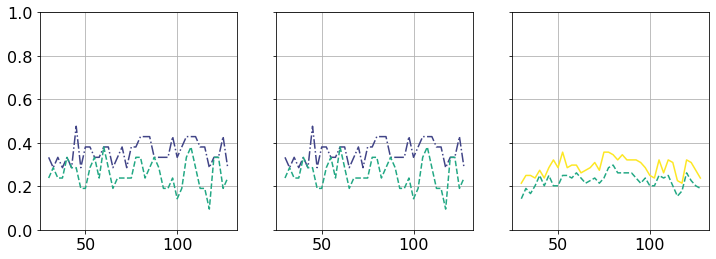

In [78]:
COL_TID = "tid_read_rate"
COL_EPC = "epc_read_rate"
COL_VEH = "vehicle_read_rate"
COL_V = "vehicle_speed"

fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3, 
                         sharex=True, sharey=True)
df = subset(DF, t=BASE_T, p=BASE_P, m=BASE_M, tid=BASE_TID, flag=BASE_FLAG)
df_front = df[df.use_tag_back==False][[COL_V, COL_TID, COL_EPC]]
df_back = df[df.use_tag_front==False][[COL_V, COL_TID, COL_EPC]]
df_both = df[[COL_V, COL_VEH, COL_TID]].groupby(COL_V, as_index=False).mean()

# Вероятность идентификации по переднему номеру
colors = [get_color(0.2), get_color(0.6), get_color(1.0)]
axes[0].plot(df_front[COL_V], df_front[COL_EPC], color=colors[0], linestyle='-.', label='Вероятность чтения EPCID')
axes[0].plot(df_front[COL_V], df_front[COL_TID], color=colors[1], linestyle='--', label='Вероятность чтения TID')
axes[1].plot(df_front[COL_V], df_front[COL_EPC], color=colors[0], linestyle='-.', label='Вероятность чтения EPCID')
axes[1].plot(df_front[COL_V], df_front[COL_TID], color=colors[1], linestyle='--', label='Вероятность чтения TID')
axes[2].plot(df_both[COL_V], df_both[COL_VEH], color=colors[2], linestyle='-', label='Вероятность идентификации автомобиля')
axes[2].plot(df_both[COL_V], df_both[COL_TID], color=colors[1], linestyle='--', label='Вероятность чтения TID')
for ax in axes:
    ax.grid()
    ax.set_ylim((0, 1))
# fig.legend(*axes[0].get_legend_handles_labels(), loc='lower center', 
#            bbox_to_anchor=(0.5, 0), ncol=3)

## Эксперимент 1: исследование влияния Tari и M на вероятность идентификации

In [27]:
DF = pd.read_csv("data/sim_data_20.csv").sort_values('vehicle_speed')
print(f"Loaded {DF.shape[0]} rows")

Loaded 520 rows


Tari = 6.25, df1 has 40 rows
[30.0, 32.5, 35.0, 37.5, 40.0, 42.5, 45.0, 47.5, 50.0, 52.5, 55.0, 57.5, 60.0, 62.5, 65.0, 67.5, 70.0, 72.5, 75.0, 77.5, 80.0, 82.5, 85.0, 87.5, 90.0, 92.5, 95.0, 97.5, 100.0, 102.5, 105.0, 107.5, 110.0, 112.5, 115.0, 117.5, 120.0, 122.5, 125.0, 127.5]
Tari = 12.5, df1 has 40 rows
[30.0, 32.5, 35.0, 37.5, 40.0, 42.5, 45.0, 47.5, 50.0, 52.5, 55.0, 57.5, 60.0, 62.5, 65.0, 67.5, 70.0, 72.5, 75.0, 77.5, 80.0, 82.5, 85.0, 87.5, 90.0, 92.5, 95.0, 97.5, 100.0, 102.5, 105.0, 107.5, 110.0, 112.5, 115.0, 117.5, 120.0, 122.5, 125.0, 127.5]
Tari = 18.75, df1 has 40 rows
[30.0, 32.5, 35.0, 37.5, 40.0, 42.5, 45.0, 47.5, 50.0, 52.5, 55.0, 57.5, 60.0, 62.5, 65.0, 67.5, 70.0, 72.5, 75.0, 77.5, 80.0, 82.5, 85.0, 87.5, 90.0, 92.5, 95.0, 97.5, 100.0, 102.5, 105.0, 107.5, 110.0, 112.5, 115.0, 117.5, 120.0, 122.5, 125.0, 127.5]
Tari = 25, df1 has 40 rows
[30.0, 32.5, 35.0, 37.5, 40.0, 42.5, 45.0, 47.5, 50.0, 52.5, 55.0, 57.5, 60.0, 62.5, 65.0, 67.5, 70.0, 72.5, 75.0, 77.5, 80.0,

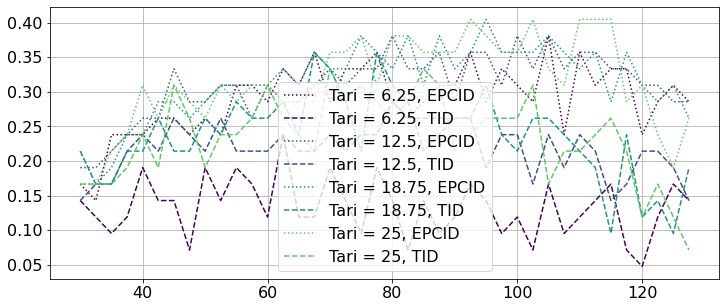

In [25]:
#
# PLOT SPEED vs ID_RATE, misc TARI
# --------------------------------
fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=1)
for i, tari in enumerate([6.25, 12.5, 18.75, 25]):
    df1 = DF[
        (DF.tari == tari) & 
        (DF.m == BASE_M) & 
        (DF.reader_tx_power == BASE_P) & 
        (DF.tid_size == BASE_TID) &
        (DF.use_tag_back == True) &
        (DF.use_tag_front == True) &
        (DF.reader_session_strategy == BASE_FLAG)
    ].sort_values(['vehicle_speed'])
    print(f"Tari = {tari}, df1 has {df1.shape[0]} rows")
    color = get_color(i/4)
    speed = df1.vehicle_speed
    print(list(speed))
    epc_read_rate = df1.epc_read_rate
    tid_read_rate = df1.tid_read_rate
    vehicle_read_rate = df1.vehicle_read_rate
    ax.plot(speed, epc_read_rate, linestyle=':', label=f"Tari = {tari}, EPCID", color=color)
    ax.plot(speed, tid_read_rate, linestyle='--', label=f"Tari = {tari}, TID", color=color)
    # ax.plot(speed, vehicle_read_rate, linestyle='-', label=f"Tari = {tari}, Vehicle", color=color)
# ax.set_ylim((0, 1))
ax.grid()
ax.legend()